# Baseline - 3D CNN - 4 Classifiers

In this notebook, we will train **four** 3D convolutional neural networks and combine their predictions in order to recognize a brain tumor.

For each case (i.e., person) we know whether the person suffered from cancer (1) or not (0). Each independent case has a dedicated folder identified by a five-digit number. Within each of these “case” folders, there are four sub-folders, each of them corresponding to an MRI scan, The MRI scans include:

* Fluid Attenuated Inversion Recovery (FLAIR)
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1Gd)
* T2-weighted (T2)

I am using the datas set created by [Jonathan Besomi](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/253000#1388021). Many thanks for creating the data set!

**3D images**
* each image has the following shape: Channel x Width x Height x Depth (i.e., 1 x Width x Height x Depth)
* *depth:* the depth represents the depth or the number of slices. (I tried various values >= 30. If for a given id, the depth <= the given value (e.g., 30), I replaced the missing depth slices with zero matrices (see [Zabir Al Nazi Nabil](https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train)))
* added some albumentation such as CLAHE, brightness, and CoarseDropout for the training images
* removed black pixels (see [Zabir Al Nazi Nabil](https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train))

**3D CNN** <br>
For each MRI type (i.e., FLAIR, T1w, T1wCE, T2w), we will creat & train a 3D CNN model, respectively with the following architecture
* 4x Conv3d layers
* 3x MaxPool3d layers
* 1x AdaptiveMaxPool3d layers
* 2x fc layers

#### Imports

In [1]:
import os
import random
import glob
import re

import pandas as pd

import numpy as np

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2

import albumentations as A

from tqdm import tqdm

import wandb

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

#### Seed

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

#### Config

In [3]:
PATH = '..'

config = dict(
    # Pre-processing
    SLICE_NUMBER = 50, # >= 30
    REMOVE_BLACK_BOUNDARIES = True,
    DATASET='PNG',
    
    # Albumentation
    RRC_SIZE = 256,
    RRC_MIN_SCALE = 0.85,
    RRC_RATIO = (1., 1.),
    CLAHE_CLIP_LIMIT = 2.0,
    CLAHE_TILE_GRID_SIZE = (8, 8),
    CLAHE_PROB = 0.50,
    BRIGHTNESS_LIMIT = (-0.2,0.2),
    BRIGHTNESS_PROB = 0.40,
    HUE_SHIFT = (-15, 15),
    SAT_SHIFT = (-15, 15),
    VAL_SHIFT = (-15, 15),
    HUE_PROB = 0.64,
    COARSE_MAX_HOLES = 16,
    COARSE_PROB = 0.7,
    
    # Training
    N_EPOCHS = 10,
    BATCH_SIZE = 8,
    LEARNING_RATE = 0.01,
    WEIGHT_DECAY = 0.02,
    
    # Logging
    VERBOSE = False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### wandb

In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "01-3D-4-BaseCNN"
wandb.login()
run = wandb.init(project='rsna-miccai', config=config)
config = wandb.config

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 01-3D-4-BaseCNN
wandb: Currently logged in as: gusto (use `wandb login --relogin` to force relogin)


### 1. Load Data

To create a 3D image, we will pick SLICE_NUMBER middle slices from each of the four MRI types (i.e., FLAIR, T1w, T1wCE, T2w). For example, if we set *SLICE_NUMBER=30*, each 3D image will have the shape: 1 x Width x Height x 30. Further, one image contains only the images from *one* MRI type as opposed to other notebooks where all MRI types are combined in a single image.

* If for a given MRI type, the number of images < SLICE_Number, than we will "fill up" the remaining *number_of_images - SLICE_NUMBER* slices with all black images
* We removed black pixels (for more information, see [here](https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train))

### 1.1 Utilities

#### 1.1.1 Augmentation

In [5]:
train_transform = A.Compose([
    A.RandomResizedCrop(
        config.RRC_SIZE, config.RRC_SIZE,            
        scale=(config.RRC_MIN_SCALE, 1.0),
        ratio=config.RRC_RATIO,
        p=1.0
    ),
    A.CLAHE(
        clip_limit=config.CLAHE_CLIP_LIMIT,
        tile_grid_size=config.CLAHE_TILE_GRID_SIZE,
        p=config.CLAHE_PROB
    ),
    A.RandomBrightnessContrast(
        brightness_limit=config.BRIGHTNESS_LIMIT,
        p=config.BRIGHTNESS_PROB
    ),
    A.HueSaturationValue(
        hue_shift_limit=config.HUE_SHIFT, 
        sat_shift_limit=config.SAT_SHIFT, 
        val_shift_limit=config.VAL_SHIFT, 
        p=config.HUE_PROB
    ),
    A.CoarseDropout(
        max_holes=config.COARSE_MAX_HOLES,
        p=config.COARSE_PROB),
])

valid_transform = A.Compose([
    A.RandomResizedCrop( 
        config.RRC_SIZE, config.RRC_SIZE,            
        scale=(config.RRC_MIN_SCALE, 1.0),
        ratio=config.RRC_RATIO,
        p=1.0
    )
])

#### 1.1.2 Loading Images

In [6]:
def get_slices(mri_type, aug):
    if config.VERBOSE:
        print(f"Length of folder: {len(mri_type)}")
    # Take SLICE_NUMBER slices from the middle
    threshold = config.SLICE_NUMBER // 2
    minimum_idx = len(mri_type)//2 - threshold if (len(mri_type)//2 - threshold) > 0 else 0
    maximum_idx = len(mri_type)//2 + threshold  # maximum can exceed the index
    if config.VERBOSE:
        print(f"Minimum {minimum_idx}")
        print(f"Maximum {maximum_idx}")
    # Create array which contains the images
    mri_img = []
    for file in mri_type[minimum_idx:maximum_idx]:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if config.REMOVE_BLACK_BOUNDARIES:
            (x, y) = np.where(img > 0)
            if len(x) > 0 and len(y) > 0:
                x_mn = np.min(x)
                x_mx = np.max(x)
                y_mn = np.min(y)
                y_mx = np.max(y)
                if (x_mx - x_mn) > 10 and (y_mx - y_mn) > 10:
                    img = img[:,np.min(y):np.max(y)]
        if aug:
            transformed = train_transform(image=img)
            img = transformed["image"]
        else:
            transformed = valid_transform(image=img)
            img = transformed["image"]
        mri_img.append(np.array(img))
    mri_img = np.array(mri_img).T
    # If less than SLICE_NUMBER slices, add SLICE_NUMBER - mri_img.shape[-1] images with only zero values
    if mri_img.shape[-1] < config.SLICE_NUMBER:
        if config.VERBOSE:
            print(f"Current slices: {mri_img.shape[-1]}")
        n_zero = config.SLICE_NUMBER - mri_img.shape[-1]
        mri_img = np.concatenate((mri_img, np.zeros((config.RRC_SIZE, config.RRC_SIZE, n_zero))), axis = -1)
    if config.VERBOSE:
        print(f"Shape of mri_img: {mri_img.shape}")
    return mri_img
    

def load_images(scan_id, mri_type, aug=True):
    if config.VERBOSE:
        print(f"Scan id {scan_id}")
        
    # Ascending sort
    if mri_type == "FLAIR":
        flair = sorted(glob.glob(f"{PATH}/train/{scan_id}/FLAIR/*.png"), key=lambda f: int(re.sub('\D', '', f)))
        img = get_slices(flair, aug)
    elif mri_type == "T1w":
        t1w = sorted(glob.glob(f"{PATH}/train/{scan_id}/T1w/*.png"), key=lambda f: int(re.sub('\D', '', f)))
        img = get_slices(t1w, aug)
    elif mri_type == "T1wCE":
        t1wce = sorted(glob.glob(f"{PATH}/train/{scan_id}/T1wCE/*.png"), key=lambda f: int(re.sub('\D', '', f)))
        img = get_slices(t1wce, aug)
    else:
        t2w = sorted(glob.glob(f"{PATH}/train/{scan_id}/T2w/*.png"), key=lambda f: int(re.sub('\D', '', f)))
        img = get_slices(t2w, aug)
    
    # Return 3D image: ChannelsxWidthxHeightxDepth
    img = img.reshape((1,config.RRC_SIZE,config.RRC_SIZE,config.SLICE_NUMBER))
    return img

#### Example

The first row represents images with augmentation and the second row images without augmentation.

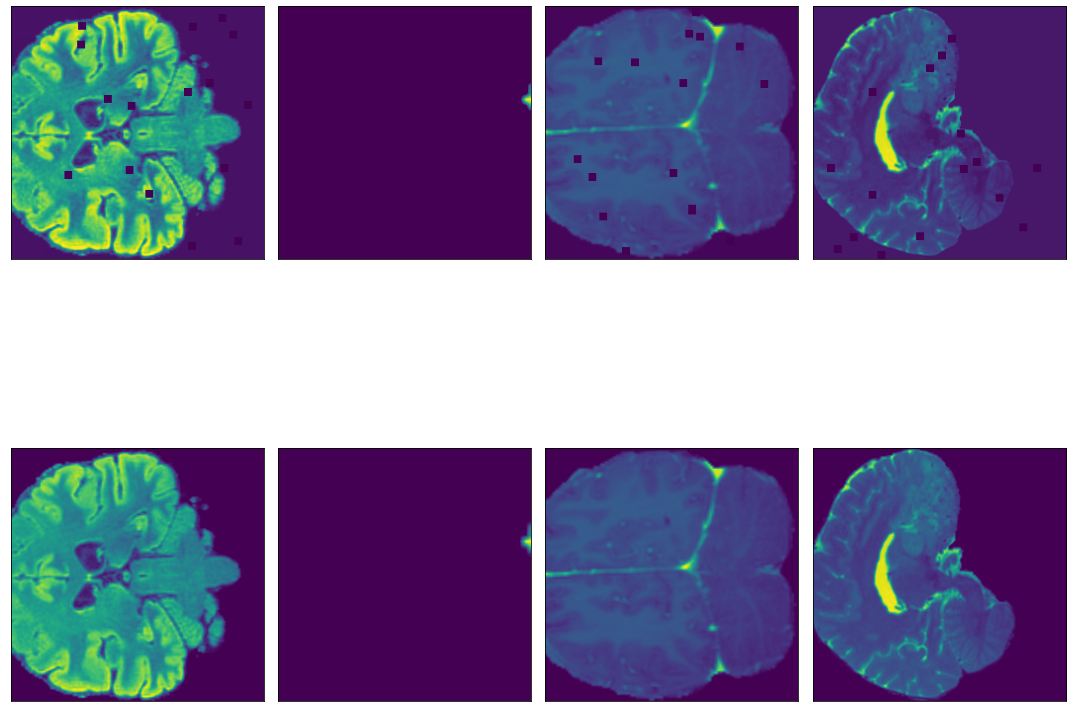

In [7]:
scan_id = "00000"
slice_nb = 0

figure, axes = plt.subplots(2,4, figsize=(15,15))

flair_3d_image = load_images(scan_id, "FLAIR", aug=True)
flair_3d_image_fs = flair_3d_image[0,:,:,slice_nb]
t1w_3d_image = load_images(scan_id, "T1w", aug=True)
t1w_3d_image_fs = t1w_3d_image[0,:,:,slice_nb]
t1wce_3d_image = load_images(scan_id, "T1wCE", aug=True)
t1wce_3d_image_fs = t1wce_3d_image[0,:,:,slice_nb]
t2w_3d_image = load_images(scan_id, "T2w", aug=True)
t2w_3d_image_fs = t2w_3d_image[0,:,:,slice_nb]

im = axes[0,0].imshow(flair_3d_image_fs)
im = axes[0,1].imshow(t1w_3d_image_fs)
im = axes[0,2].imshow(t1wce_3d_image_fs)
im = axes[0,3].imshow(t2w_3d_image_fs)

for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])

flair_3d_image = load_images(scan_id, "FLAIR", aug=False)
flair_3d_image_fs = flair_3d_image[0,:,:,slice_nb]
t1w_3d_image = load_images(scan_id, "T1w", aug=False)
t1w_3d_image_fs = t1w_3d_image[0,:,:,slice_nb]
t1wce_3d_image = load_images(scan_id, "T1wCE", aug=False)
t1wce_3d_image_fs = t1wce_3d_image[0,:,:,slice_nb]
t2w_3d_image = load_images(scan_id, "T2w", aug=False)
t2w_3d_image_fs = t2w_3d_image[0,:,:,slice_nb]

im = axes[1,0].imshow(flair_3d_image_fs)
im = axes[1,1].imshow(t1w_3d_image_fs)
im = axes[1,2].imshow(t1wce_3d_image_fs)
im = axes[1,3].imshow(t2w_3d_image_fs)

for ax in axes[1]:
    ax.set_xticks([])
    ax.set_yticks([])

figure.tight_layout()
plt.show()

### 1.2 Dataset and Dataloader

Create a PyTorch Dataset and DataLoader **for each** MRI type

In [8]:
class RSNADataset(Dataset):
    def __init__(self, path='../', split = "train", mri_type = "FLAIR", validation_split = 0.2):
        train_data = pd.read_csv(os.path.join(path, 'train_labels.csv'))
        self.labels = {}
        self.mri_type = mri_type
        brats = list(train_data["BraTS21ID"])
        mgmt = list(train_data["MGMT_value"])
        for b, m in zip(brats, mgmt):
            self.labels[str(b).zfill(5)] = m
            
        remove_ids = ["00709", "00109", "00123"]
            
        if split == "valid":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob((path + f"/train/" + "/*")), key=lambda f: int(re.sub('\D', '', f)))]
            self.ids = self.ids[:int(len(self.ids) * validation_split)] # first 20% as validation
        elif split == "train":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob((path + f"/train/" + "/*")), key=lambda f: int(re.sub('\D', '', f)))]
            self.ids = self.ids[int(len(self.ids) * validation_split):] # last 80% as train
        elif split == "test":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob((path + f"/test/" + "/*")), key=lambda f: int(re.sub('\D', '', f)))]
        else:
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob((path + f"/train/" + "/*")), key=lambda f: int(re.sub('\D', '', f)))]
        
        self.ids = [id_ for id_ in self.ids if id_ not in remove_ids]            
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        if self.split == "train":
            imgs = load_images(self.ids[idx], aug=True, mri_type=self.mri_type)
        else:
            imgs = load_images(self.ids[idx], aug=False, mri_type=self.mri_type)

        if self.split != "test":
            label = self.labels[self.ids[idx]]
            return torch.tensor(imgs, dtype = torch.float32), torch.tensor(label, dtype = torch.long)
        else:
            return torch.tensor(imgs, dtype = torch.float32)

In [9]:
# FLAIR DataLoader
train_flair_ds = RSNADataset(mri_type="FLAIR")
train_flair_dl = DataLoader(train_flair_ds, batch_size=config.BATCH_SIZE, shuffle=True)
valid_flair_ds = RSNADataset(mri_type="FLAIR", split='valid')
valid_flair_dl = DataLoader(valid_flair_ds, batch_size=config.BATCH_SIZE, shuffle=False)

In [10]:
# T1w DataLoader
train_t1w_ds = RSNADataset(mri_type="T1w")
train_t1w_dl = DataLoader(train_t1w_ds, batch_size=config.BATCH_SIZE, shuffle=True)
valid_t1w_ds = RSNADataset(mri_type="T1w", split='valid')
valid_t1w_dl = DataLoader(valid_t1w_ds, batch_size=config.BATCH_SIZE, shuffle=False)

In [11]:
# T1wCE DataLoader
train_t1wce_ds = RSNADataset(mri_type="T1wCE")
train_t1wce_dl = DataLoader(train_t1wce_ds, batch_size=config.BATCH_SIZE, shuffle=True)
valid_t1wce_ds = RSNADataset(mri_type="T1wCE", split='valid')
valid_t1wce_dl = DataLoader(valid_t1wce_ds, batch_size=config.BATCH_SIZE, shuffle=False)

In [12]:
# T2w DataLoader
train_t2w_ds = RSNADataset(mri_type="T2w")
train_t2w_dl = DataLoader(train_t2w_ds, batch_size=config.BATCH_SIZE, shuffle=True)
valid_t2w_ds = RSNADataset(mri_type="T2w", split='valid')
valid_t2w_dl = DataLoader(valid_t2w_ds, batch_size=config.BATCH_SIZE, shuffle=False)

In [13]:
images, labels = next(iter(train_flair_dl))
print(f"Shape of the batch {images.shape}")
print(f"Batch size: {images.shape[0]}")
print(f"Number of channels each image has: {images.shape[1]}")
print(f"Size of each image is: {images.shape[2]}x{images.shape[3]}")
print(f"Depth of each channel/sequence: {images.shape[-1]}")

Shape of the batch torch.Size([8, 1, 256, 256, 50])
Batch size: 8
Number of channels each image has: 1
Size of each image is: 256x256
Depth of each channel/sequence: 50


### 1.3 Model

In [18]:
def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=2):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### 1.4 Training

Create a model for each MRI type, respectively.

#### 1.4.0 Trainings Loop

In [15]:
def one_hot(arr):
    return [[1, 0] if a_i == 0 else [0, 1] for a_i in arr]

def training(net, n_epochs, optimizer, loss_function, scheduler, train_dl, valid_dl, mri_type):
    wandb.watch(net, loss_function, log='all', log_freq=10)
    # Store the losses for each epoch
    loss_train_list = []
    loss_valid_list = []

    # Store the roc for each epoch
    roc_train_list = []
    roc_valid_list = []
    
    best_roc = 0.0

    # Iterate over the dataset n_epochs times
    for epoch in range(n_epochs):
        net.train()  # net.train() will notify all your layers that you are in training mode

        train_loss = 0  # Training loss in epoch
        y_train_list = []
        y_hat_train_list = []
        roc_train = 0.0

        # For each batch, pass the training examples, calculate loss and gradients and optimize the parameters
        for xb, yb in tqdm(train_dl, desc="Training"):
            optimizer.zero_grad()  # zero_grad clears old gradients from the last step

            xb = xb.to(device)
            yb = yb.to(device)

            y_hat = net(xb)  # Forward pass
            loss = loss_function(y_hat, yb)  # Calculate Loss

            loss.backward()  # Calculate the gradients (using backpropagation)
            optimizer.step()  # # Optimize the parameters: opt.step() causes the optimizer to take a step based on the gradients of the parameters.

            train_loss += loss.item()
            y_train_list.extend(yb.tolist())
            y_hat_train_list.extend(y_hat.tolist())

        roc_train += roc_auc_score(one_hot(y_train_list), y_hat_train_list)
                
        wandb.log({"epoch": epoch, "train_loss": train_loss, "train_roc": roc_train})

        valid_loss = 0  # Validation loss in epoch
        y_valid_list = []
        y_hat_valid_list = []
        roc_valid = 0.0

        net.eval()  # net.eval() will notify all your layers that you are in evaluation mode
        with torch.no_grad():
            # Perform a prediction on the validation set  
            for xb_valid, yb_valid in tqdm(valid_dl, desc="Validation"):
                xb_valid = xb_valid.to(device)
                yb_valid = yb_valid.to(device)

                y_hat = net(xb_valid)  # Forward pass
                loss = loss_function(y_hat, yb_valid)  # Calculate Loss

                valid_loss += loss.item()
                y_valid_list.extend(yb_valid.tolist())
                y_hat_valid_list.extend(y_hat.tolist())

        roc_valid += roc_auc_score(one_hot(y_valid_list), y_hat_valid_list)
        scheduler.step(valid_loss)

        wandb.log({"epoch": epoch, "test_loss": valid_loss, "test_roc": roc_valid})

        loss_train_list.append(train_loss)
        loss_valid_list.append(valid_loss)
        roc_train_list.append(roc_train)
        roc_valid_list.append(roc_valid)
        
        if roc_valid > best_roc:
            best_roc = roc_valid
            torch.save(net.state_dict(), f'../models/01-3D-4-BaseCNN-{mri_type}-roc-{round(best_roc, 2)}.pt')

    return roc_train_list, roc_valid_list, loss_train_list, loss_valid_list

In [19]:
# Create Loss Function
loss_function = nn.CrossEntropyLoss()

def utilities():
    # Create model
    model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes())

    # Create optimizer
    optimizer = torch.optim.AdamW(model.parameters(),lr = config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)

    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.25)

    model.to(device)
    
    return model, optimizer, scheduler

#### 1.4.1 FLAIR model

In [20]:
flair_model, optimizer, scheduler = utilities()

roc_train, roc_valid, loss_train, loss_valid = training(flair_model, config.N_EPOCHS, optimizer, loss_function, scheduler, train_flair_dl,
                                                        valid_flair_dl, mri_type="FLAIR")

Validation: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


#### 1.4.2 T1w model

In [21]:
t1w_model, optimizer, scheduler = utilities()

roc_train, roc_valid, loss_train, loss_valid = training(t1w_model, config.N_EPOCHS, optimizer, loss_function, scheduler, train_t1w_dl,
                                                        valid_t1w_dl, mri_type="T1w")

Validation: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


#### 1.4.3 T1wCE model

In [22]:
t1wce_model, optimizer, scheduler = utilities()

roc_train, roc_valid, loss_train, loss_valid = training(t1wce_model, config.N_EPOCHS, optimizer, loss_function, scheduler, train_t1wce_dl,
                                                        valid_t1wce_dl, mri_type="T1wCE")

Validation: 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


#### 1.4.4 T2w model

In [23]:
t2w_model, optimizer, scheduler = utilities()

roc_train, roc_valid, loss_train, loss_valid = training(t2w_model, config.N_EPOCHS, optimizer, loss_function, scheduler, train_t2w_dl,
                                                        valid_t2w_dl, mri_type="T2w")

Validation: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


### 1.5 Evaluation

In [50]:
def evaluation(net, valid_dl):
    
    ys_hats = None
    
    net.eval()  # net.eval() will notify all your layers that you are in evaluation mode
    with torch.no_grad():
        # Perform a prediction on the validation set  
        for xb_valid, yb_valid in valid_dl:
            xb_valid = xb_valid.to(device)
            yb_valid = yb_valid.to(device)

            y_hat = net(xb_valid)  # Forward pass
            y_hat = F.softmax(y_hat)
            if ys_hats is None:
                ys_hats = y_hat.cpu().detach().numpy()
            else:
                ys_hats = np.concatenate((ys_hats, y_hat.cpu().detach().numpy()), axis=0)

    return ys_hats

In [51]:
flair_y_hat = evaluation(flair_model, valid_flair_dl)
t1w_y_hat = evaluation(t1w_model, valid_t1w_dl)
t1wce_y_hat = evaluation(t1wce_model, valid_t1wce_dl)
t2w_y_hat = evaluation(t2w_model, valid_t2w_dl)

In [57]:
df = pd.read_csv('../train_labels.csv')
df = df.iloc[0:int(df.shape[0]*0.2),:]
df = df.loc[(df.BraTS21ID != 123) & (df.BraTS21ID != 109)]
df["FLAIR"] = flair_y_hat[:,1].tolist()
df["T1w"] = t1w_y_hat[:,1].tolist()
df["T1wCE"] = t1wce_y_hat[:,1].tolist()
df["T2w"] = t2w_y_hat[:,1].tolist()
df["y_hat"] = (df["FLAIR"] + df["T1w"] + df["T1wCE"] + df["T2w"]) / 4
print(roc_auc_score(df["MGMT_value"], df["y_hat"]))

0.663030303030303


In [58]:
df.head()

,BraTS21ID,MGMT_value,FLAIR,T1w,T1wCE,T2w,y_hat
0,0,1,0.708572,0.549354,0.543500,0.622185,0.605903
1,2,1,0.674747,0.549354,0.543366,0.593424,0.590223
2,3,0,0.706085,0.549330,0.543372,0.606287,0.601268
3,5,1,0.751133,0.548616,0.542413,0.608228,0.612597
4,6,1,0.746754,0.549356,0.543855,0.596349,0.609078


In [59]:
run.finish()

Run pip install nbformat to save notebook history


epoch,9
train_loss,40.33761
train_roc,0.57747
_runtime,6938
_timestamp,1627498000
_step,80
test_loss,10.266
test_roc,0.61773


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
train_loss,▄▂▃▁▁▁▁▁▁▁▆▃▂▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▆▁▂▁▁▁▁▁▁▁
train_roc,▄▅▅▂▄▃▅▄▆▄▃▄▃▄▄▄▄▁▂▄▄▂▃▄▃▃▃▁▁▂▃▅▄▂▄▆▆▇█▇
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▂▂█▁▁▁▁▁▁▁▃▂▂▃▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
test_roc,▁▁▂▆▅▄█▂▅▇▁▁▁▂▂▄▄▄▄▄▂▃▄▄▅▃▄▅▂▅▃▅▆▅▅▇▆▇▆▆


Done